In [1]:
from kaggle_secrets import UserSecretsClient
import wandb

# Lấy secret từ Kaggle secrets manager
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")

# Đăng nhập wandb
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hoangviet852004 (hoangviet852004-vku) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import torchvision.models as models
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score


import seaborn as sns
import pandas as pd


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 2. Path dataset
train_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/train/"
val_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/val/"
test_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/test/"

In [4]:
# 3. Hàm lấy đường dẫn ảnh
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

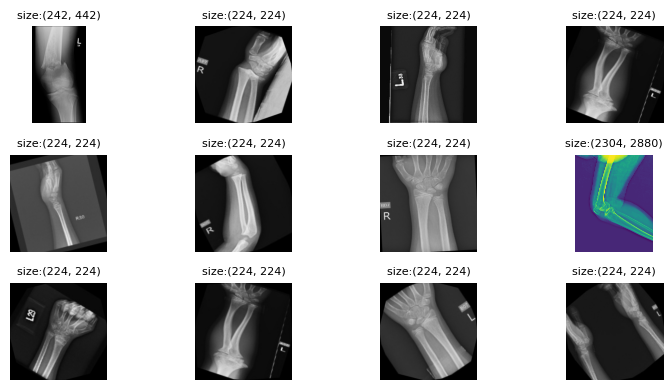

In [5]:
# 4. Hàm hiển thị dữ liệu
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [6]:
# 5. Xử lý hình ảnh RGBA, LA, P
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode == 'RGBA' or img.mode == 'LA':
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA')
            img = img.convert('L')
        else:
            img = img.convert('L')
        return img

In [7]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

In [9]:
print(f"Số lượng lớp trong tập huấn luyện: {len(train_ds.classes)}")
print(f"Các lớp trong tập huấn luyện: {train_ds.classes}")
print(f"Số lượng lớp trong tập kiểm tra: {len(val_ds.classes)}")
print(f"Các lớp trong tập kiểm tra: {val_ds.classes}")

Số lượng lớp trong tập huấn luyện: 2
Các lớp trong tập huấn luyện: ['fractured', 'not fractured']
Số lượng lớp trong tập kiểm tra: 2
Các lớp trong tập kiểm tra: ['fractured', 'not fractured']


In [10]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

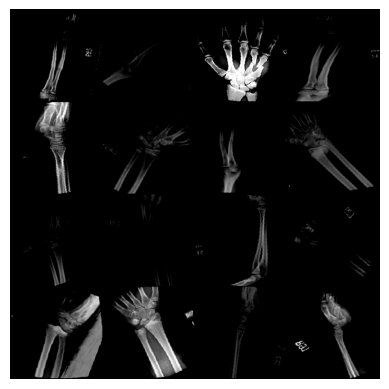

In [11]:
# 8. Xem thử batch ảnh
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [12]:
# 9. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# 10. Load mô hình và chỉnh sửa
model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=2)

# Freeze toàn bộ model
for param in model.parameters():
    param.requires_grad = False

# Fine-tune layer4 và classifier
for param in model.layer4.parameters():
    param.requires_grad = True

# Sửa Conv2d đầu vào cho ảnh grayscale
model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=model.conv1.out_channels,
    kernel_size=model.conv1.kernel_size,
    stride=model.conv1.stride,
    padding=model.conv1.padding,
    bias=(model.conv1.bias is not None)
)

# Thêm Dropout vào fc
in_features = model.get_classifier().in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)

model = model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
# 11. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()

# Chỉ train phần requires_grad=True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [15]:
wandb.init(
    project="fracture-classification",
    name="resnet18-3-binary",
    config={
        "model": "resnet18",
        "epochs": 20,
        "batch_size": 64,
        "lr": 1e-4,
        "optimizer": "AdamW",
        "scheduler": "StepLR",
        "loss": "CrossEntropyLoss",
        "dropout": 0.3,
        "image_size": 224,
        "dataset": "Bone_Fracture_Binary"
    }
)

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250804_154405-4dtoq7al
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run resnet18-3-binary
wandb: ⭐️ View project at https://wandb.ai/hoangviet852004-vku/fracture-classification
wandb: 🚀 View run at https://wandb.ai/hoangviet852004-vku/fracture-classification/runs/4dtoq7al


In [16]:
# 12. Train/validate
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc, all_labels, all_preds

def train(model, train_dl, val_dl, criterion, optimizer, scheduler, epochs=20):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
        val_loss, acc, labels, preds = validate(model, val_dl, criterion)
        scheduler.step()
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss, "val_accuracy": acc})
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Acc {acc:.2f}%")
    return labels, preds

In [17]:
labels, preds = train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler)

 31%|███       | 4/13 [00:03<00:06,  1.29it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


Epoch 1: Train Loss 0.6513 | Val Loss 0.5942 | Acc 77.32%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 2: Train Loss 0.5271 | Val Loss 0.5085 | Acc 75.03%


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 3: Train Loss 0.3977 | Val Loss 0.3867 | Acc 82.75%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 4: Train Loss 0.2992 | Val Loss 0.2939 | Acc 88.18%


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 5: Train Loss 0.2361 | Val Loss 0.2737 | Acc 88.66%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 6: Train Loss 0.2083 | Val Loss 0.2624 | Acc 89.38%


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch 7: Train Loss 0.1817 | Val Loss 0.2421 | Acc 89.87%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 8: Train Loss 0.1619 | Val Loss 0.2251 | Acc 91.44%


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch 9: Train Loss 0.1506 | Val Loss 0.2179 | Acc 91.19%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 10: Train Loss 0.1368 | Val Loss 0.2141 | Acc 91.56%


100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 11: Train Loss 0.1306 | Val Loss 0.2043 | Acc 92.04%


100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 12: Train Loss 0.1282 | Val Loss 0.2028 | Acc 91.19%


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 13: Train Loss 0.1214 | Val Loss 0.1983 | Acc 91.68%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 14: Train Loss 0.1198 | Val Loss 0.1991 | Acc 92.04%


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 15: Train Loss 0.1112 | Val Loss 0.1923 | Acc 91.68%


100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 16: Train Loss 0.1147 | Val Loss 0.1931 | Acc 92.04%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 17: Train Loss 0.1084 | Val Loss 0.1896 | Acc 91.68%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 18: Train Loss 0.1082 | Val Loss 0.1871 | Acc 91.56%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 19: Train Loss 0.1073 | Val Loss 0.1845 | Acc 91.92%


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

Epoch 20: Train Loss 0.1050 | Val Loss 0.1903 | Acc 91.44%


In [18]:
# 13. Save model
os.makedirs("FracturedDataResNet18", exist_ok=True)
torch.save(model.state_dict(), "FracturedDataResNet18/model.pt")
wandb.save("FracturedDataResNet18/model.pt")

['/kaggle/working/wandb/run-20250804_154405-4dtoq7al/files/FracturedDataResNet18/model.pt']

In [19]:
# 14. Test evaluation
test_ds = ImageFolder(test_path, transform=val_transforms)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = get_predictions(model, test_dl)

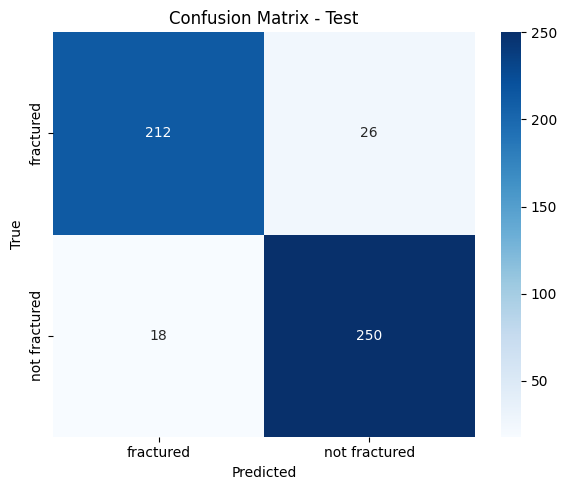

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=test_ds.classes, columns=test_ds.classes), annot=True, fmt="d", cmap="Blues", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.show()

In [21]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_ds.classes, output_dict=True)
wandb.log({"classification_report": report})
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.92      0.89      0.91       238
not fractured       0.91      0.93      0.92       268

     accuracy                           0.91       506
    macro avg       0.91      0.91      0.91       506
 weighted avg       0.91      0.91      0.91       506



In [22]:
# Overall Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
wandb.log({"test_accuracy": acc, "test_precision": precision, "test_recall": recall, "test_f1": f1})
print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9130
Precision: 0.9138
Recall   : 0.9118
F1 Score : 0.9126
